Creating basic API call from Alpaca

In [2]:
# importing requisite libraries
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
import json

In [3]:
load_dotenv()

Python-dotenv could not parse statement starting at line 7
Python-dotenv could not parse statement starting at line 8


True

In [23]:
ticker_symbol = ["JPM"]

In [24]:
def get_dat_data(ticker):
    """Function to automatically pull closing price data from Alpaca"""
    """  example syntax: get_dat_data(["TSLA"])  """
    
    # Insert Personal Secret Keys (check .ENV to match syntax if error occurs)
    alpaca_api_key = os.getenv("APCA_API_KEY_ID")
    alpaca_secret_key = os.getenv("APCA_API_SECRET_KEY")
    # Create the Alpaca API object
    alpaca = tradeapi.REST(
        alpaca_api_key,
        alpaca_secret_key,
        api_version= "v2")
    
    # Backdating the Data to the first day of 2020
    back_date = pd.Timestamp("2020-01-01", tz="America/New_York").isoformat()

    # Choosing the ticker we want (need to figure out how to make this the input)
    #ticker = ["TSLA"]
    
    # Using our assumption of 15min intervals for trading
    timeframe = "15Min"
    
    # Creating a dataframe with every characteristic of ticker Alpaca allows
    df_ticker = alpaca.get_barset(
        ticker,
        timeframe,
        start=back_date
        ).df
    
    # Selecting only the closing price for the ticker
    closing_price = pd.DataFrame()

    for time_period in ticker:
        closing_price[time_period] = df_ticker[time_period]["close"]

    closing_price.dropna()

    closing_price.rename(columns= {closing_price.columns[0]: "close"}, inplace=True)
    closing_price = pd.DataFrame(closing_price)
    return closing_price

In [27]:
get_dat_data(ticker_symbol).to_csv("../Resources/JPM.csv")

In [20]:
# Bollinger Band function to capture signal
def bollinger_band_signal_generator(dataframe_name, closing_price_column_name = 'close', bollinger_band_window = 20, num_standard_deviation = 2):
    """Creates Bollinger Band indicator with signal for long position based on closing price
    Args:
        dataframe_name (dict): Single security dataframe containing at least closing prices
        closing_price_column_name (str): Name of column in dataframe containing closing prices
        bollinger_band_window (int): Desired timeframe window used for rolling calculations
        num_standard_deviation (int): Desired number of standard deviations to calculate
    Returns:
        A dataframe of:
            original data passed to function,
            bollinger_band_middle (flt): Column of values for middle band,
            bollinger_band_std (flt): Column of values to calculate standard deviation,
            bollinger_band_upper (flt): Column of values for upper band,
            bollinger_band_lower (flt): Column of values for lower band,
            bollinger_band_long (flt): Column of generated signals (1.0 = True, 0.0 = False)
    """
    # Calculate mean and standard deviation
    dataframe_name['bollinger_band_middle'] = dataframe_name[closing_price_column_name].rolling(window=bollinger_band_window).mean()
    dataframe_name['bollinger_band_std'] = dataframe_name[closing_price_column_name].rolling(window=bollinger_band_window).std()

    # Calculate upper bollinger band and lower bollinger band
    dataframe_name['bollinger_band_upper'] = dataframe_name['bollinger_band_middle'] + (dataframe_name['bollinger_band_std'] * num_standard_deviation)
    dataframe_name['bollinger_band_lower'] = dataframe_name['bollinger_band_middle'] - (dataframe_name['bollinger_band_std'] * num_standard_deviation)

    # Create signal column
    dataframe_name['bollinger_band_long'] = np.where(dataframe_name[closing_price_column_name] > dataframe_name['bollinger_band_upper'], 1.0, 0.0)
    
    # Drop NaN values
    dataframe_name.dropna(inplace=True)

    # Return dataframe with features and target
    return dataframe_name


In [22]:
bollinger_band_signal_generator(get_dat_data(ticker_symbol), "close")

,close,bollinger_band_middle,bollinger_band_std,bollinger_band_upper,bollinger_band_lower,bollinger_band_long
2020-01-02 14:15:00-05:00,140.730,140.19825,0.420517,141.039285,139.357215,0.0
2020-01-02 14:30:00-05:00,140.870,140.25825,0.426742,141.111734,139.404766,0.0
2020-01-02 14:45:00-05:00,140.980,140.32375,0.432200,141.188150,139.459350,0.0
2020-01-02 15:00:00-05:00,140.870,140.38525,0.417030,141.219311,139.551189,0.0
2020-01-02 15:15:00-05:00,140.820,140.45625,0.357023,141.170296,139.742204,0.0
...,...,...,...,...,...,...
2021-01-07 14:45:00-05:00,135.870,136.32150,0.796491,137.914482,134.728518,0.0
2021-01-07 15:00:00-05:00,135.775,136.25475,0.782754,137.820258,134.689242,0.0
2021-01-07 15:15:00-05:00,135.655,136.13250,0.660830,137.454160,134.810840,0.0
2021-01-07 15:30:00-05:00,135.730,136.03350,0.551300,137.136100,134.930900,0.0


Practice Bollinger

In [7]:

def bollinger_band(get_dat_data):
    closing_price = pd.DataFrame(get_dat_data(ticker_symbol))
    # Window size
    bollinger_band_window = 20
    num_standard_deviation = 2

    # Calculate mean and standard deviation
    closing_price['bollinger_band_middle'] = closing_price['close'].rolling(window=bollinger_band_window).mean()
    closing_price['bollinger_band_std'] = closing_price['close'].rolling(window=bollinger_band_window).std()

    # Calculate upper bollinger band and lower bollinger band
    closing_price['bollinger_band_upper'] = closing_price['bollinger_band_middle'] + (closing_price['bollinger_band_std'] * num_standard_deviation)
    closing_price['bollinger_band_lower'] = closing_price['bollinger_band_middle'] - (closing_price['bollinger_band_std'] * num_standard_deviation)
    # Create signal for long
    closing_price['bollinger_band_long'] = np.where(closing_price['close'] > closing_price['bollinger_band_upper'], 1.0, 0.0)
    closing_price.loc[closing_price['bollinger_band_long'] == 1.0].head()
    closing_price.dropna(inplace=True)
    # Plot Bollinger Bands with closing prices to visually see data
    return closing_price[['close', 'bollinger_band_middle', 'bollinger_band_upper', 'bollinger_band_lower']].plot(figsize=(20,10), title='AAPL Bollinger Bands')

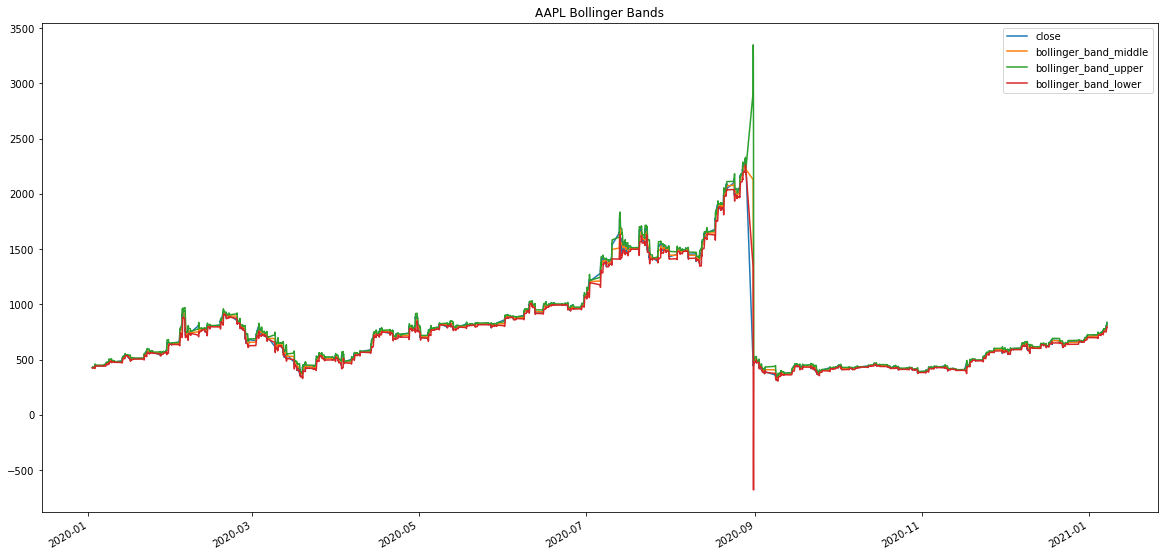

In [8]:
bollinger_band(get_dat_data)

ROUGH DRAFT FOR ALPACA API

In [3]:
# Bringing in alpaca api keys
alpaca_api_key = os.getenv("APCA_API_KEY_ID")
alpaca_secret_key = os.getenv("APCA_API_SECRET_KEY")
# Create the Alpaca API object
# YOUR CODE HERE!
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version= "v2")

In [4]:
# testing alpaca keys
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpca Secret Key type: <class 'str'>


In [10]:
# Defining timeframe and ticker parameters for my API pull
current_date = pd.Timestamp("2020-01-01", tz="America/New_York").isoformat()

ticker = ["JPM"]

timeframe = "15Min"

In [11]:
# Creating dataframe with every feature on Alpaca's get_barset
df_ticker = alpaca.get_barset(
    ticker,
    timeframe,
    start=current_date
).df

df_ticker.head()

JPM                                 
                              open    high      low    close volume
2020-01-02 09:30:00-05:00  140.070  140.14  139.520  139.670  29953
2020-01-02 09:45:00-05:00  139.675  139.91  139.440  139.670  24343
2020-01-02 10:00:00-05:00  139.635  139.81  139.520  139.640  19021
2020-01-02 10:15:00-05:00  139.600  139.60  139.340  139.400  18856
2020-01-02 10:30:00-05:00  139.460  139.54  139.280  139.535  19695
...                            ...     ...      ...      ...    ...
2021-01-06 12:15:00-05:00  131.670  131.96  131.665  131.960  22992
2021-01-06 12:30:00-05:00  131.960  132.30  131.920  132.280  17191
2021-01-06 12:45:00-05:00  132.275  132.58  131.960  132.580  20470
2021-01-06 13:00:00-05:00  132.615  132.65  132.265  132.360  21793
2021-01-06 13:15:00-05:00  132.350  132.55  132.350  132.460   3561

[6857 rows x 5 columns]

In [17]:
# Creating a clsing price dataframe. Had to get a little weird with this code. 
closing_price = pd.DataFrame()

for time_period in ticker:
    closing_price[x] = df_ticker[time_period]["close"]

closing_price.head()


,JPM
2020-01-02 09:30:00-05:00,139.670
2020-01-02 09:45:00-05:00,139.670
2020-01-02 10:00:00-05:00,139.640
2020-01-02 10:15:00-05:00,139.400
2020-01-02 10:30:00-05:00,139.535
